# Summary
Use Tensorboard to build and train a neural net for recognizing 
# Conclusion
The Neural net has mediocre overall performance, likely because I didn't spend that much time optimizing it, and because the problem is somewhat ill-posed, since a string could be a word in multiple different languages. However, for English and Mandarin words it did better than the guessing rate of 33%, which means learning was successful.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import string
import math
import tabulate
import os

# Make training data

In [2]:
# Define constants for the training data
WORD_LENGTH = 20
feature_length = 26*WORD_LENGTH
languages = "english french mandarin".split()
num_of_languages = len(languages)

# Constants for saving
save_dir = '.\\nn_save\\'

# Function for converting words to vectors
# Letters are stored as a list of 26 integers, all 0 except for one, which is a 1
# E.g. a is [1, 0, 0... <25 0's>]
# E.g. z is [0, 0 ... <25 0's>, 1]
# Overall 20 letters are stored sequentially
# Punctuation and white space is ignored
def vectorize_word(word):
    l_final = []
    for i in range(WORD_LENGTH):
        l_next = [0]*26
        try:
            l_next[string.ascii_lowercase.index(word[i])] = 1
        except:
            pass
        l_final.extend(l_next)
    return l_final

f_out = open(r'.\data\nn_params.txt', 'w')
f_out.write("{}\n".format(WORD_LENGTH))
f_out.write(save_dir+'\n')
f_out.write(" ".join(languages)+'\n')
f_out.close()

In [3]:
# Create training data
training_data = []
training_answers = []
for i, lang in enumerate(languages):
    
    # Read files
    f_in = open(".\data\{}.txt".format(lang))
    words = [w.strip() for w in f_in.readlines()]
    f_in.close()
    
    # Vectorize words
    vector_words = [vectorize_word(w) for w in words]
    
    # Vectorize output
    l = [0]*num_of_languages
    l[i] = 1
    vector_language = [l for w in words]
    
    # Add to training data
    training_data.extend(vector_words)
    training_answers.extend(vector_language)
    
# Convert data to numpy array
training_data = np.array(training_data)
training_answers = np.array(training_answers)

In [4]:
# Summarize training data
print("Training data shape: {}".format(training_data.shape))

Training data shape: (24786, 520)


# Make the neural net

In [5]:
# Input and output variables
x = tf.placeholder(tf.float32, [None, feature_length])
y_ = tf.placeholder(tf.float32, [None, num_of_languages])

# Define the number of neurons in each layer
layer_lengths = [feature_length, 40, num_of_languages]

# Create each layer
neural_net = []
last_output = x
for i, current_layer_length in enumerate(layer_lengths[1:]):
    
    # Define the length of the last layer
    last_layer_length = layer_lengths[i]
    
    # Create the variables for this layer
    W = tf.Variable(tf.truncated_normal([last_layer_length, current_layer_length],
                                        stddev=1 / math.sqrt(last_layer_length)))
    b = tf.Variable(tf.constant(0.1, shape=[current_layer_length]))
    h = tf.sigmoid(tf.matmul(last_output, W) + b)
    
    # Store the variables for this layer
    neural_net.append((W, b, h))
    
    # Update the last output
    last_output = h

# Output layer (softmax)
y = tf.nn.softmax(last_output)

# Scoring (use cross-entropy storing)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=1))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

## Train Neural net and output accuracy

Batch 02000- 0.6160 (15267/24786)
Batch 04000- 0.6442 (15966/24786)
Batch 06000- 0.6826 (16919/24786)
Batch 08000- 0.7060 (17500/24786)
Batch 10000- 0.7183 (17803/24786)
Batch 12000- 0.7263 (18003/24786)
Batch 14000- 0.7313 (18127/24786)
Batch 16000- 0.7327 (18160/24786)
Batch 18000- 0.7351 (18219/24786)
Batch 20000- 0.7357 (18234/24786)
Batch 22000- 0.7369 (18264/24786)
Batch 24000- 0.7396 (18331/24786)
Batch 26000- 0.7401 (18343/24786)
Batch 28000- 0.7413 (18373/24786)
Batch 30000- 0.7431 (18418/24786)
Batch 32000- 0.7447 (18458/24786)
Batch 34000- 0.7463 (18498/24786)
Batch 36000- 0.7484 (18551/24786)
Batch 38000- 0.7498 (18585/24786)
Batch 40000- 0.7511 (18617/24786)


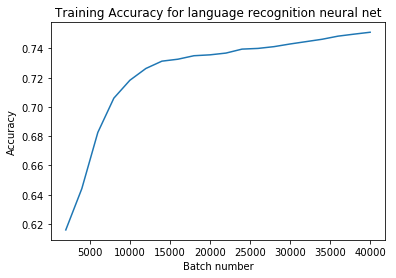

In [6]:
# Initialize variables
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

# Initialize accuracy metrics
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_tracker = []

# Run the training
batch_size = 500
for i in range(40000):
    batch_indices = np.random.randint(training_data.shape[0], size=batch_size)
    batch_xs = training_data[batch_indices]
    batch_ys = training_answers[batch_indices]
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
    # Possibly print readout
    if (i+1) % 2000 == 0:
        corr_pred = sess.run(correct_prediction, feed_dict={x: training_data, y_: training_answers})
        correct, total = len(corr_pred[corr_pred]), len(corr_pred)
        acc = float(correct)/total
        accuracy_tracker.append((i+1, acc))
        print("Batch {:0>5d}- {:.4f} ({:0>5d}/{})".format(i+1, acc, correct, total))
        
# Plot training accuracy improvement
plt.plot(*zip(*accuracy_tracker))
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.title("Training Accuracy for language recognition neural net")
plt.show()

In [7]:
# Function for testing words
def get_predictions(test_words):
    test_words_vectorized = np.array([vectorize_word(w) for w in test_words])

    # Get predictions
    test_results = sess.run(y, feed_dict={x: test_words_vectorized})
    
    return test_results

# Function that tests words and prints them to make a nice pretty table
def predictions_table(test_words, answers=None):
    # test_words is a list of strings (the words)
    # Answers will tell the net if it is correct
    # Should be a list where the number n of element i correspond means that test_words[i] is of language[n]
    predictions = get_predictions(test_words)
    table = [[w] for w in test_words] # First column of the table is the word
    table = [t + ["{:.1f}".format(p*100) for p in pred] for t, pred in zip(table, predictions)]  # Next column is the predictions
    headers = ["Word"] + [l.title() for l in languages]
    
    # Possibly print wrong answers
    if answers is not None:
        
        # Find the ones it answered correctly
        correct = np.array([p[i] == np.max(p) for p, i in zip(predictions, answers)])
        
        # Add an answers column to the table
        for i, c in enumerate(correct):
            if c:
                table[i] += [""]
            else:
                table[i] += ["Wrong!"]
        headers += ["Correct?"]
        
    # Print the table:
    print(tabulate.tabulate(table, headers=headers))
    
    # Possibly print the accuracy
    if answers is not None:
        print("Accuracy: {:.2f}%".format(100.*len(correct[correct])/len(correct)))

# Test the neural net with some words I made up
## This isn't the most rigorous source of test data admittedly, but oh well

In [8]:
# English words
english_words = "hello my dear chap let's have a bit of coffee".split()
english_words += "oh my heavens look at what this neural net can do".split()
english_words += "it looks like english words are often quite similar to french ones".split()
predictions_table(english_words, answers=[0]*len(english_words))

Word       English    French    Mandarin  Correct?
-------  ---------  --------  ----------  ----------
hello         57.2      21.6        21.2
my            57.5      21.4        21.1
dear          50.1      30.7        19.2
chap          56.4      21          22.5
let's         53.5      26.7        19.7
have          57        22          21
a             56.3      23          20.7
bit           57.3      21.5        21.2
of            57.4      21.5        21.1
coffee        21.4      57.5        21.2  Wrong!
oh            56.6      20.9        22.5
my            57.5      21.4        21.1
heavens       40        43.3        16.7  Wrong!
look          57.6      21.2        21.2
at            55.5      24          20.4
what          56        20.6        23.3
this          53.5      21.8        24.7
neural        26.8      53.3        20    Wrong!
net           55.1      24.6        20.3
can           49.3      25.3        25.4
do            56.2      22.8        21
it            5

### It is pretty good at English.
Most words were right, with most of the confusion mainly being with French (which has a lot of similar words anyways).  
Oddly enough it thought the word "quite" was Mandarin.

In [9]:
# French words
# Note the lack of accents (the vectorizer doesn't handle accents)
# Note my poor French also
french_words = "bonjour mon ami j'adore le francais. C'est une belle langue".split()
french_words += "je mange une croissant avec une baguette et du brie".split()
french_words += "ca c'est comment on fait des choses en france!".split()
predictions_table(french_words, answers=[1]*len(french_words))

Word         English    French    Mandarin  Correct?
---------  ---------  --------  ----------  ----------
bonjour         20.8      23.7        55.5  Wrong!
mon             55.7      22.9        21.4  Wrong!
ami             44.2      39.2        16.6  Wrong!
j'adore         41.3      42.8        16
le              57.1      21.6        21.2  Wrong!
francais.       43.5      40.4        16    Wrong!
C'est           52.3      28.4        19.2  Wrong!
une             57.6      21.2        21.2  Wrong!
belle           44.3      39.3        16.4  Wrong!
langue          21.2      21.3        57.6  Wrong!
je              53.3      23.6        23.1  Wrong!
mange           21.2      21.4        57.3  Wrong!
une             57.6      21.2        21.2  Wrong!
croissant       42.1      42.3        15.6
avec            42.8      41.4        15.8  Wrong!
une             57.6      21.2        21.2  Wrong!
baguette        24.6      55.1        20.3
et              52.6      28          19.4  Wrong!


### It really didn't do very well with French at all...
It seemed to mix it up with English a lot. I am not sure why the confusion is so uneven...

In [10]:
# Mandarin Words
# Note I am typing in pinyin with no tones
mandarin_words = "xuexi zhongwen zhende hen nan".split()
mandarin_words += "wo hen xihuan pinyin yinwei bangzhu wo kanshu de bijiao rongyi".split()
mandarin_words += "sishisi jiu shi tebie nan shuochulai".split()
mandarin_words += "qilai, bu yuan zuo nuli de renmen!".split()  # Gotta please the censors ;)
predictions_table(mandarin_words, answers=[2]*len(mandarin_words))

Word          English    French    Mandarin  Correct?
----------  ---------  --------  ----------  ----------
xuexi            21.2      21.2        57.6
zhongwen         21.2      21.2        57.6
zhende           21.3      21.2        57.5
hen              47.5      20.7        31.8  Wrong!
nan              37.5      23.4        39.1
wo               57.6      21.2        21.3  Wrong!
hen              47.5      20.7        31.8  Wrong!
xihuan           21.2      21.2        57.6
pinyin           21.5      21.1        57.4
yinwei           21.2      21.2        57.6
bangzhu          21.2      21.2        57.6
wo               57.6      21.2        21.3  Wrong!
kanshu           21.2      21.2        57.6
de               55.4      23.4        21.3  Wrong!
bijiao           21.2      21.2        57.6
rongyi           28.6      19.4        52.1
sishisi          54.1      23.4        22.5  Wrong!
jiu              21.2      21.7        57.1
shi              31.9      19.9        48.3
tebie 

### It did ok with Mandarin
Most of the confusion seems to be with short words (e.g. 'hen', which is a word in english too).  
I found it weird that "tebie" and "renmen" were French...

In [11]:
# Save neural net
# saver = tf.train.Saver()
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# save_path = saver.save(sess, save_dir)
# print(save_path)

In [12]:
# Close the session
# sess.close()